### This notebook takes the pretrained model from paper 
Kraft, M.; Aszkowski, P.; Pieczyński, D.; Fularz, M. Low-Cost Thermal Camera-Based Counting Occupancy Meter Facilitating Energy Saving in Smart Buildings. Energies 2021, 14, 4542.
https://doi.org/10.3390/en14154542
### adjust the in and output size and is retrained for fisheye

In [37]:
import numpy as np
import os 
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import cv2

In [38]:
# class WeightedMAE(tf.keras.metrics.Metric):
#     def __init__(self, name='weighted_mae', **kwargs):
#         super().__init__(name=name, **kwargs)
#         self.total_error = self.add_weight(name='total_error', initializer='zeros')
#         self.count = self.add_weight(name='count', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         weights = tf.reduce_sum(y_true, axis=[1, 2], keepdims=True) + 1e-8
#         abs_error = tf.abs(y_true - y_pred)
#         weighted_error = tf.reduce_sum(abs_error * y_true, axis=[1, 2]) / weights[..., 0, 0]
#         self.total_error.assign_add(tf.reduce_sum(weighted_error))
#         self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

#     def result(self):
#         return self.total_error / self.count

#     def reset_states(self):
#         self.total_error.assign(0.0)
#         self.count.assign(0.0)

# def get_weighted_mae(weight_factor=40.0):
#     def loss(y_true, y_pred):
#         weights = tf.where(y_true > 0, weight_factor, 1.0)
#         return tf.reduce_mean(tf.abs(y_true - y_pred) * weights)
#     return loss

# def count_mae(y_true, y_pred):
#     true_count = tf.reduce_sum(y_true, axis=[1, 2, 3])  
#     pred_count = tf.reduce_sum(y_pred, axis=[1, 2, 3])
#     return tf.reduce_mean(tf.abs(true_count - pred_count))

In [39]:
model_flex = tf.keras.models.load_model("models/dens_paper_pretrained.keras", compile=False)#, custom_objects={'count_mae': count_mae, 'loss': get_weighted_mae(), 'WeightedMAE': WeightedMAE()})

### Functions to load in a dataset


In [40]:
#own random flip function to flip the image and dens the same way.

def random_flip(image, density_map):
    flip = tf.less(tf.random.uniform([]), 0.5)
    image = tf.cond(flip, lambda: tf.image.flip_left_right(image), lambda: image)
    density_map = tf.cond(flip, lambda: tf.image.flip_left_right(density_map), lambda: density_map)
    
    flip_ud = tf.less(tf.random.uniform([]), 0.5)
    image = tf.cond(flip_ud, lambda: tf.image.flip_up_down(image), lambda: image)
    density_map = tf.cond(flip_ud, lambda: tf.image.flip_up_down(density_map), lambda: density_map)

    return image, density_map

In [41]:
def _load_npy_file(npy_path):
    return np.load(npy_path.decode("utf-8")).astype(np.float32)

def load_pair(img_path, gaus_path, size=128, training=True):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.rgb_to_grayscale(image)

    image = tf.image.resize(image, (size, size))

    image = tf.cast(image, tf.float32) / 255.0 #-> img input range [0,1]
    
    den_map = tf.numpy_function(_load_npy_file, [gaus_path], tf.float32)
    den_map.set_shape([size, size])  # Must set shape manually
    den_map = tf.expand_dims(den_map, axis=-1)  # Shape [H, W, 1]

    if training:
        image = tf.image.random_brightness(image, max_delta=0.3)
        image, den_map = random_flip(image, den_map)

    return image, den_map

In [42]:
def create_dataset(path, img_sub='images', gaus_sub="labels_gaus"):
    img_path = f"{path}/{img_sub}"
    dens_path = f"{path}/{gaus_sub}"

    img_list = [os.path.join(img_path, f) for f in os.listdir(img_path)]

    gaus_list = [os.path.join(dens_path, os.path.basename(f.replace(".jpg", ".npy"))) for f in img_list]

    return tf.data.Dataset.from_tensor_slices((img_list, gaus_list)), len(img_list)

### Custom function to get total MAE

In [43]:
def get_total_count(x):
    return np.sum(x)

### Pre-training test

In [44]:
path_dir = "../../dataset/hc/val"
img_dir = "test_show"

dataset, size = create_dataset(path_dir, img_dir)

show = (dataset
          .map(lambda f, c: load_pair(f, c, training=False), 
               num_parallel_calls=tf.data.AUTOTUNE)
          .batch(size)
          .prefetch(tf.data.AUTOTUNE))

out = model_flex.predict(show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


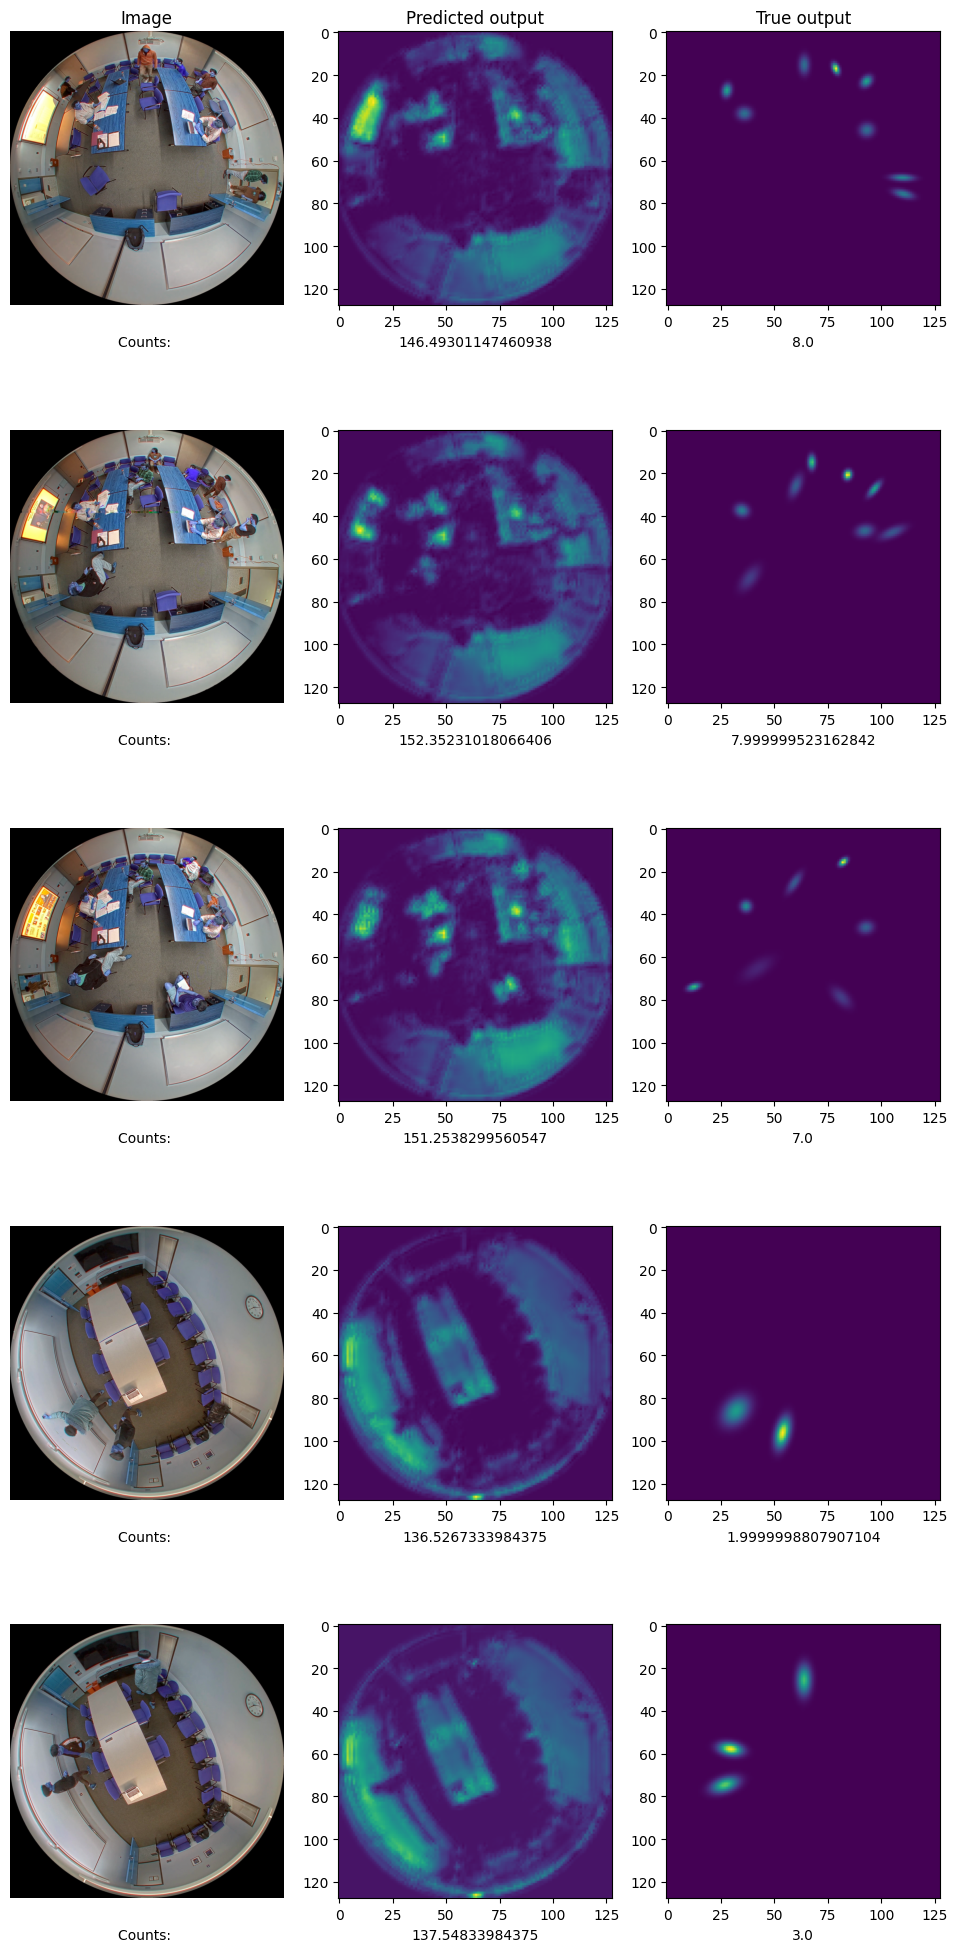

In [45]:
fig, ax = plt.subplots(len(out), 3, figsize=(12, len(out)*5))
i = 0

ax[0][0].set_title("Image")
ax[0][1].set_title("Predicted output")
ax[0][2].set_title("True output")

for image in os.listdir(path_dir + "/" + img_dir):
    img = cv2.imread(f"{path_dir}/{img_dir}/{image}")

    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][0].text(0.5, -0.15, 'Counts: ', transform=ax[i][0].transAxes, ha='center', fontsize=10)
    
    ax[i][1].imshow(out[i])
    ax[i][0].axis('off')
    ax[i][1].text(0.5, -0.15, f"{get_total_count(out[i])}", transform=ax[i][1].transAxes, ha='center', fontsize=10)
    
    gaus = np.load(f"{path_dir}/labels_gaus/{image.replace('.jpg', '.npy')}")
    ax[i][2].imshow(gaus)
    ax[i][0].axis('off')
    ax[i][2].text(0.5, -0.15, f"{get_total_count(gaus)}", transform=ax[i][2].transAxes, ha='center', fontsize=10)


    i += 1

### Training


In [46]:
dataset, size = create_dataset("../../dataset/hc/train")

dataset = dataset.shuffle(size, reshuffle_each_iteration=True)

ratio = 0.8
train_size = int(size * ratio)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

train = (train_ds
            .shuffle(len(train_ds))            
            .map(lambda f, c: load_pair(f, c, training=True), 
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)                          
            .prefetch(tf.data.AUTOTUNE))

val = (val_ds
          .map(lambda f, c: load_pair(f, c, training=False), 
               num_parallel_calls=tf.data.AUTOTUNE)
          .batch(32)
          .prefetch(tf.data.AUTOTUNE))

In [47]:
dataset_30, size_30 = create_dataset("../../dataset/hc/train", "images_person", "labels_gaus_cut")

dataset_30 = dataset_30.shuffle(size_30, reshuffle_each_iteration=True)

ratio = 0.8
train_size = int(size * ratio)
train_ds_30 = dataset_30.take(train_size)
val_ds_30 = dataset_30.skip(train_size)

train_30 = (train_ds_30
            .shuffle(len(train_ds_30))            
            .map(lambda f, c: load_pair(f, c, size=30, training=True), 
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)                          
            .prefetch(tf.data.AUTOTUNE))

val_30 = (val_ds_30
          .map(lambda f, c: load_pair(f, c, size=30, training=False), 
               num_parallel_calls=tf.data.AUTOTUNE)
          .batch(32)
          .prefetch(tf.data.AUTOTUNE))

In [48]:
initial_learning_rate = 0.001

def count_mae(y_true, y_pred):
    true_count = tf.reduce_sum(y_true, axis=[1, 2, 3])  
    pred_count = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    return tf.reduce_mean(tf.abs(true_count - pred_count))

def get_weighted_mae(weight_factor=30.0):
    def loss(y_true, y_pred):
        weights = tf.where(y_true > 0, weight_factor, 1.0)
        return tf.reduce_mean(tf.abs(y_true - y_pred) * weights)
    return loss

# def count_loss(y_true, y_pred):
#     mse = tf.reduce_mean(tf.square(y_true - y_pred))
#     count_true = tf.reduce_sum(y_true, axis=[1,2,3])  # sum over HWC
#     count_pred = tf.reduce_sum(y_pred, axis=[1,2,3])
#     count_error = tf.reduce_mean(tf.square(count_true - count_pred))
#     return mse + 0.1 * count_error  # weight the count loss

model_flex.compile(optimizer="adam", 
              loss=get_weighted_mae(weight_factor=30.0), 
              metrics=[count_mae])

First train on people snippets

In [49]:
NUM_EPOCHS = 10

lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1,
                                                 mode='auto', min_delta=0.001, cooldown=0, min_lr=0)

start_time = time.time()
model_flex.fit(train_30,
          epochs=NUM_EPOCHS,
          validation_data=val,
          callbacks=[lr_scheduler_callback])

print(f"Total training time = {time.time() - start_time:.2f} seconds")

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - count_mae: 1.8790 - loss: 0.0877 - val_count_mae: 1.7304 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - count_mae: 0.7954 - loss: 0.0386 - val_count_mae: 5.6152 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - count_mae: 0.6328 - loss: 0.0369 - val_count_mae: 8.5008 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - count_mae: 0.6017 - loss: 0.0366 - val_count_mae: 18.0230 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - count_mae: 0.5668 - loss: 0.0383 - val_count_mae: 12.3545 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 6/10
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - count_mae: 0.6374 - loss: 0.0364
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - count_mae: 0.6372 - lo

In [50]:
NUM_EPOCHS = 5

checkpoint_filepath = 'models/dens_paper_trained.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

start_time = time.time()
model_flex.fit(train,
          epochs=NUM_EPOCHS,
          validation_data=val,
          callbacks=[lr_scheduler_callback, model_checkpoint_callback])

print(f"Total training time = {time.time() - start_time:.2f} seconds")

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - count_mae: 7.6866 - loss: 0.0214 - val_count_mae: 10.2375 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - count_mae: 6.7212 - loss: 0.0140 - val_count_mae: 7.5320 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 997ms/step - count_mae: 5.7696 - loss: 0.0121 - val_count_mae: 5.8660 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 945ms/step - count_mae: 6.1296 - loss: 0.0115 - val_count_mae: 6.0494 - val_loss: 0.0118 - learning_rate: 1.0000e-04
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - count_mae: 6.3237 - loss: 0.0117 - val_count_mae: 6.8306 - val_loss: 0.0121 - learning_rate: 1.0000e-04
Total training time = 81.40 seconds


### Validate on a test set

In [51]:
dataset, size = create_dataset("../../dataset/hc/val")

test = (dataset
          .map(lambda f, c: load_pair(f, c, training=False), 
               num_parallel_calls=tf.data.AUTOTUNE)
          .batch(32)
          .prefetch(tf.data.AUTOTUNE))

In [53]:
model_trained = tf.keras.models.load_model('models/dens_paper_trained.keras', compile=True, custom_objects={'count_mae': count_mae, 'loss': get_weighted_mae(weight_factor=30.0)})

loss0, count_mae0 = model_trained.evaluate(test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 646ms/step - count_mae: 6.7176 - loss: 0.0126


In [54]:
dataset, size = create_dataset("../../dataset/hc/val", 'test_show_person', "labels_gaus_cut")

show = (dataset
          .map(lambda f, c: load_pair(f, c, size=30, training=False), 
               num_parallel_calls=tf.data.AUTOTUNE)
          .batch(size)
          .prefetch(tf.data.AUTOTUNE))

out = model_trained.predict(show)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


validation on person snippets

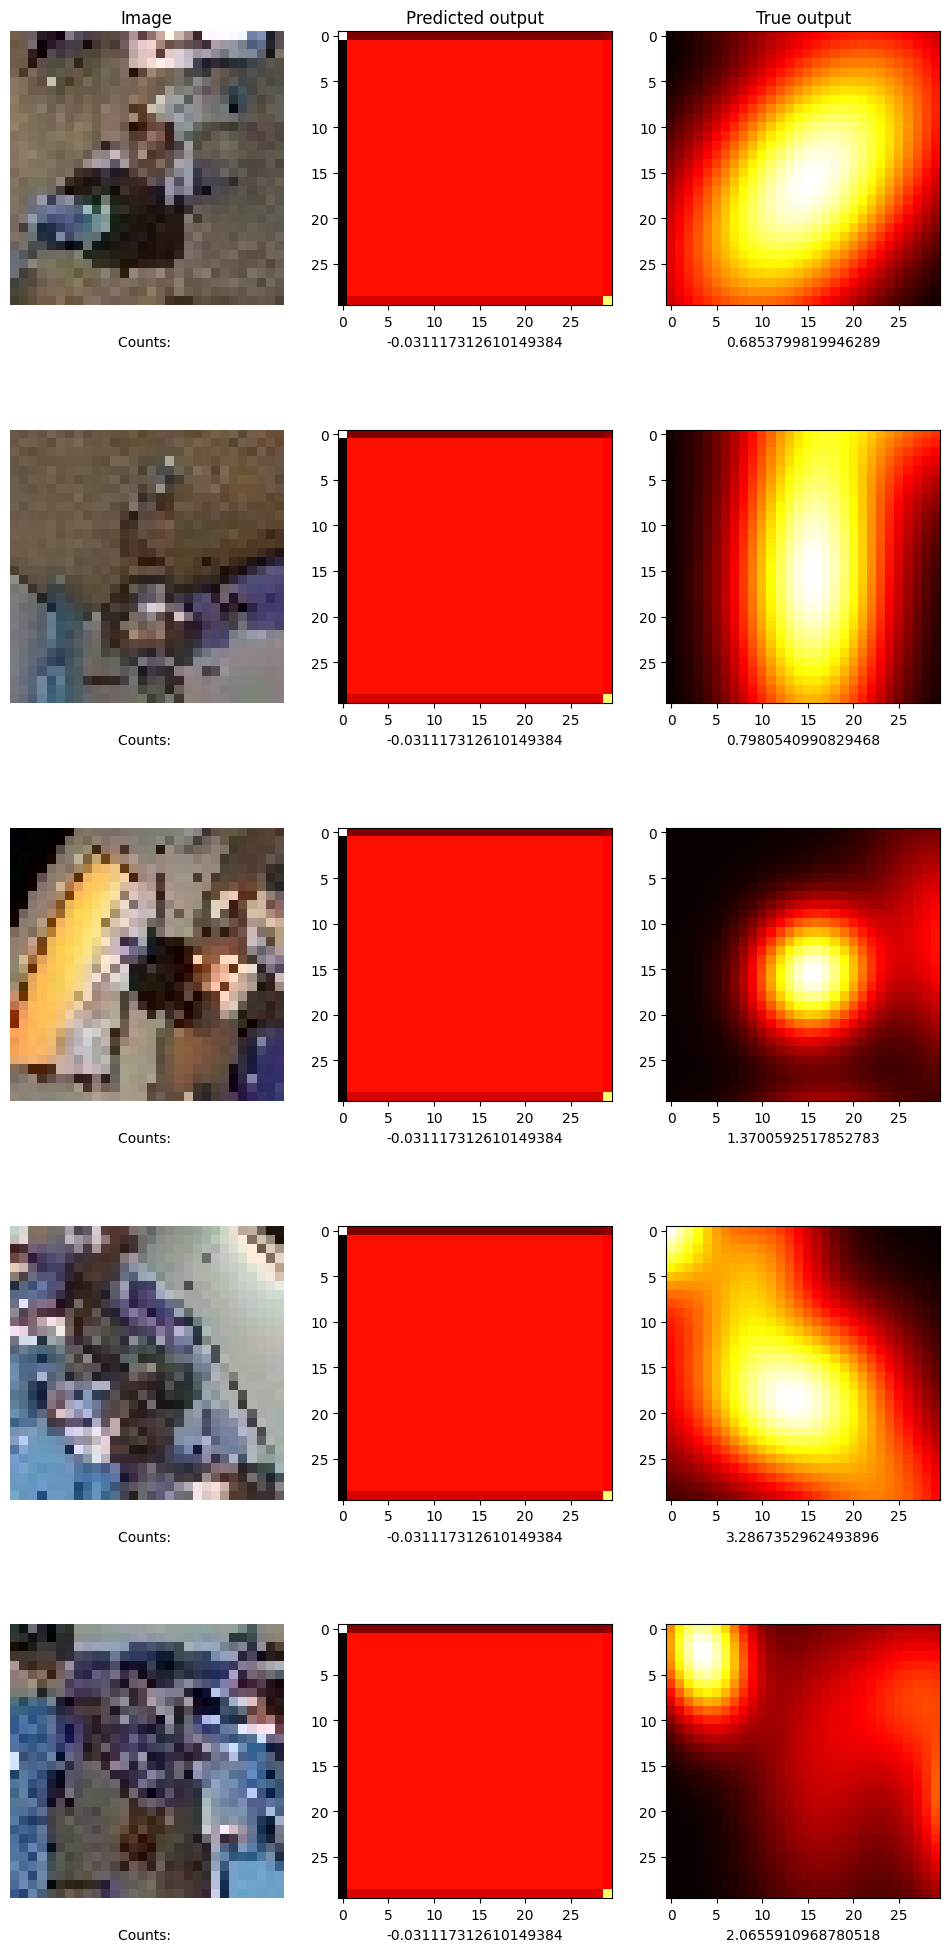

In [57]:
path_dir = "../../dataset/hc/val"
img_dir = "test_show_person"

fig, ax = plt.subplots(len(out), 3, figsize=(12, len(out)*5))
ax[0][0].set_title("Image")
ax[0][1].set_title("Predicted output")
ax[0][2].set_title("True output")

i = 0

for image in os.listdir(path_dir + "/" + img_dir):
    img = cv2.imread(f"{path_dir}/{img_dir}/{image}")

    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][0].text(0.5, -0.15, 'Counts: ', transform=ax[i][0].transAxes, ha='center', fontsize=10)
    
    ax[i][1].imshow(out[i], cmap="hot")
    ax[i][0].axis('off')
    ax[i][1].text(0.5, -0.15, f"{get_total_count(out[i])}", transform=ax[i][1].transAxes, ha='center', fontsize=10)
    
    gaus = np.load(f"{path_dir}/labels_gaus_cut/{image.replace('.jpg', '.npy')}")
    ax[i][2].imshow(gaus, cmap="hot")
    ax[i][0].axis('off')
    ax[i][2].text(0.5, -0.15, f"{get_total_count(gaus)}", transform=ax[i][2].transAxes, ha='center', fontsize=10)

    i += 1


validation on full images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


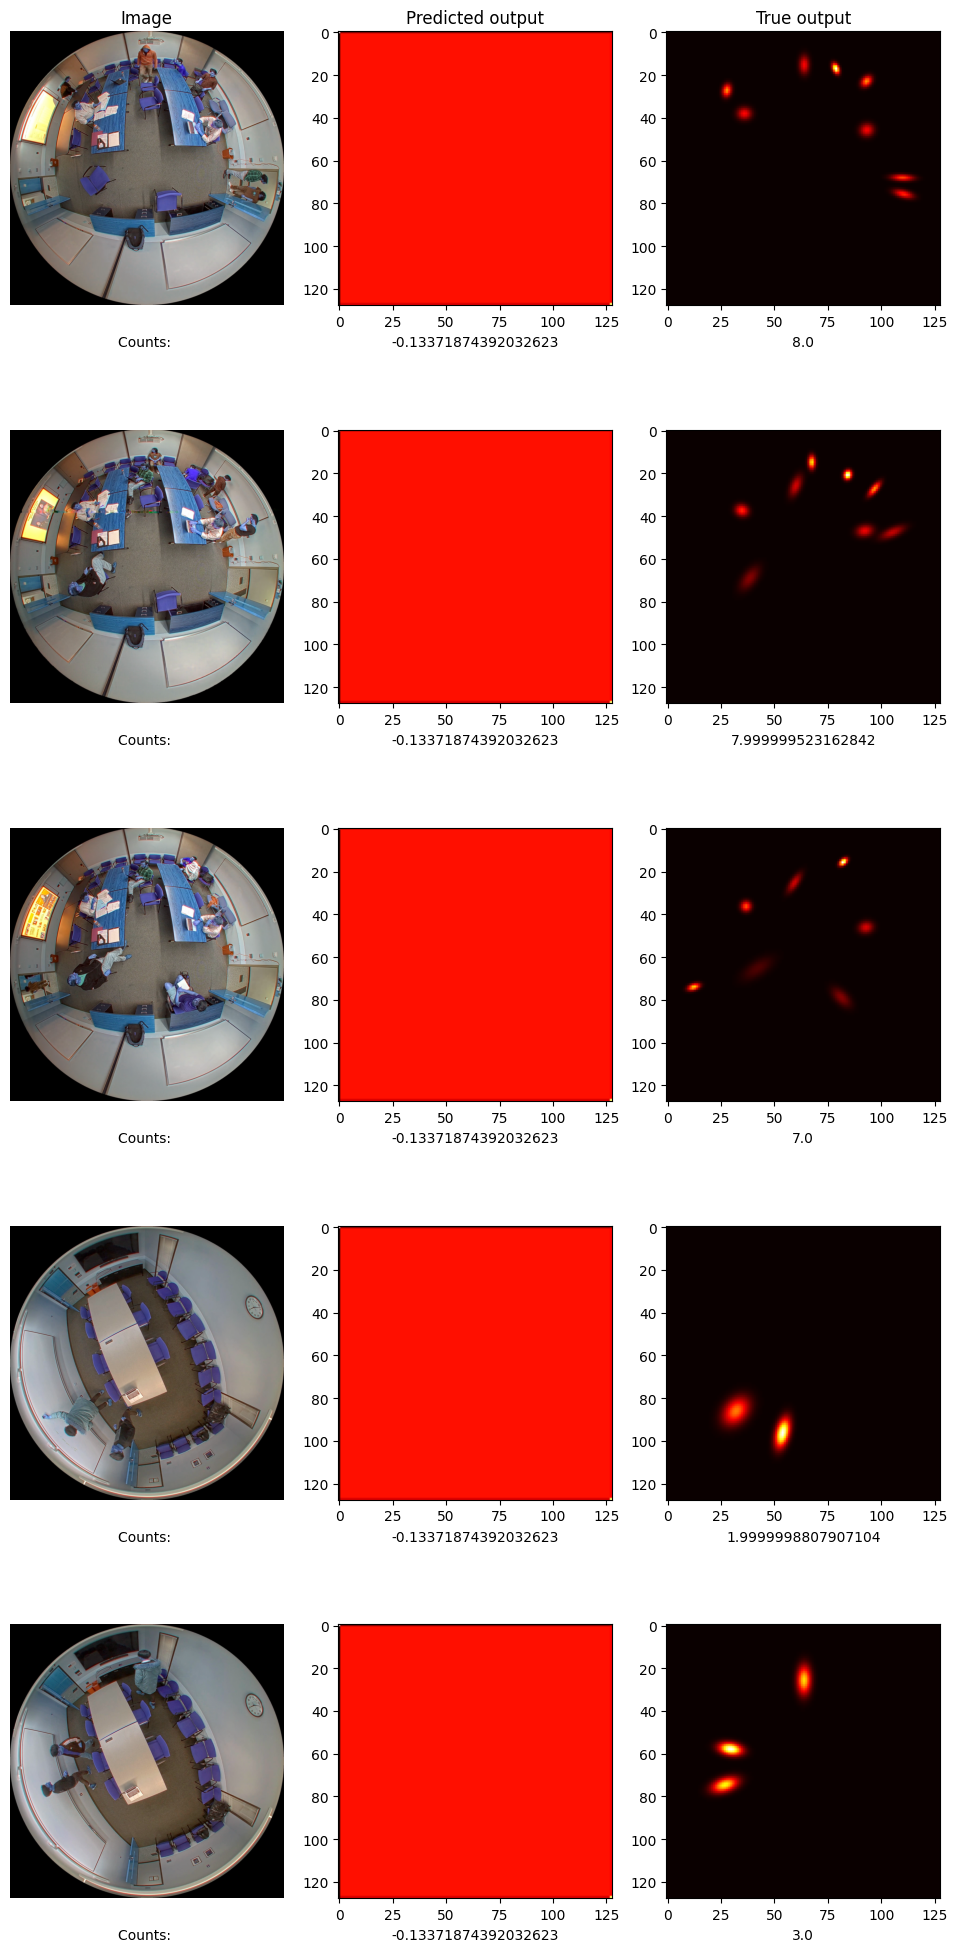

In [61]:
path_dir = "../../dataset/hc/val"
img_dir = "test_show"

dataset, size = create_dataset(path_dir, img_dir)

show = (dataset
          .map(lambda f, c: load_pair(f, c, training=False), 
               num_parallel_calls=tf.data.AUTOTUNE)
          .batch(size)
          .prefetch(tf.data.AUTOTUNE))

out = model_trained.predict(show)

fig, ax = plt.subplots(len(out), 3, figsize=(12, len(out)*5))
ax[0][0].set_title("Image")
ax[0][1].set_title("Predicted output")
ax[0][2].set_title("True output")

i = 0

for image in os.listdir(path_dir + "/" + img_dir):
    img = cv2.imread(f"{path_dir}/{img_dir}/{image}")

    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][0].text(0.5, -0.15, 'Counts: ', transform=ax[i][0].transAxes, ha='center', fontsize=10)
    
    ax[i][1].imshow(out[i], cmap="hot")
    ax[i][0].axis('off')
    ax[i][1].text(0.5, -0.15, f"{get_total_count(out[i])}", transform=ax[i][1].transAxes, ha='center', fontsize=10)
    
    gaus = np.load(f"{path_dir}/labels_gaus/{image.replace('.jpg', '.npy')}")
    ax[i][2].imshow(gaus, cmap="hot")
    ax[i][0].axis('off')
    ax[i][2].text(0.5, -0.15, f"{get_total_count(gaus)}", transform=ax[i][2].transAxes, ha='center', fontsize=10)

    i += 1